In [1]:
import pandas as pd
from functools import reduce
from math import sqrt,pi,exp
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import find_peaks,find_peaks_cwt
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import stats
import os
#code for sdf file

parent_directory = '/content/'
sdf_files = [file for file in os.listdir(parent_directory) if file.endswith('.sdf')]

subdirectory_names= []
for i in sdf_files:
  subdirectory_names.append(i.split(".sdf")[0])



In [2]:

def file_generate(cas_number):
  file_path = parent_directory+cas_number+".sdf"
  if not os.path.exists(file_path):
    return None

  # Replace 'cgi_file_path' with the actual path to your CGI file
  cgi_file_path = file_path

  # Read the file
  with open(cgi_file_path, 'r') as file:
    lines = file.readlines()

  # Initialize variables to store the IR frequency data
  ir_data = []

  # Find the start and end lines of the IR frequency data
  start_line = None
  end_line = None
  for idx, line in enumerate(lines):
    if "> <IR.FREQUENCIES>" in line:
      start_line = idx + 2 # Skip header line
    elif start_line is not None and line.strip() == '':
      end_line = idx
      break

  # Extract IR frequency data
  if start_line is not None and end_line is not None:
    for line in lines[start_line:end_line]:
      freq, intensity = map(float, line.strip().split())
      ir_data.append({'Frequency': freq, 'Intensity': intensity})

  # Create a pandas DataFrame from the extracted data
  ir_df = pd.DataFrame(ir_data,columns=None)
  return ir_df


In [3]:
feature_vectors=[]
cas_no = []
a=[]
b=[]
for i in range (len(subdirectory_names)):
  file_name = file_generate(subdirectory_names[i])

  if (not isinstance(file_name,pd.DataFrame)) or file_name.empty:
    print(subdirectory_names[i])
    continue
  cas_no.append(subdirectory_names[i])
  x_values = file_name['Frequency']
  y_values = file_name['Intensity']
  x = np.around(x_values).astype(int)
  new_x = list(range(1,4001))

  # Create the old DataFrame
  old_data = {'common_column': x, 'value_column': y_values}
  old_df = pd.DataFrame(old_data)

  # Create the new DataFrame with the common column values you want
  new_data = {'common_column': new_x}
  new_df = pd.DataFrame(new_data)

  # Merge the new DataFrame with the old DataFrame based on the common column
  merged_df = new_df.merge(old_df, on='common_column', how='left')

  # Fill missing values with zeros
  merged_df['value_column'] = merged_df['value_column'].fillna(0)
  b= merged_df['value_column']
  smoothed = []

  # gaussian function
  def gaussian_kernel(x, mean, sigma):
    return np.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * np.sqrt(2 * np.pi))


  for i in merged_df['common_column'].to_list():
    kv = gaussian_kernel(merged_df['common_column'],i,10)
  #   kv /= kv.sum()
    smoothed.append((merged_df['value_column']*kv).sum())

  # # Calculate the sum of the list
  max_val = max(smoothed)
  # # Normalize the list
  normalized_list = [x / max_val for x in smoothed]

    # now produce features for the model
  # Reshape the array into a 2D array of shape (num_rows, 5)

  elements_to_remove = len(normalized_list) % 5

  # Use slicing to remove elements from the beginning of the list
  normalized_list = normalized_list[elements_to_remove:]
  print("normalized_lst is",len(normalized_list))
  second_row = normalized_list
  a=normalized_list
  smoothed = []
  reshaped_array = np.array(normalized_list).reshape(-1, 5)
  # Calculate the mean along the rows
  eva_des = np.mean(reshaped_array, axis=1)

  # Check if the list length exceeds 600
  if len(eva_des) > 800:
    excess = len(eva_des) - 800 # Calculate the number of excess elements

    # Trim the list by removing 'excess' elements from both the beginning and end
    trimmed_list = eva_des[excess // 2:-excess // 2]

    # Now 'trimmed_list' contains at most 600 elements
  else:
    trimmed_list = eva_des # If the list is already 600 elements or less, no need to trim
    feature_vectors.append(trimmed_list)

df = pd.DataFrame(feature_vectors, columns=None)
df.insert(loc = 0,
     column = 'cas_no',
     value = cas_no)

normalized_lst is 4000


In [4]:


df.head()

,cas_no,0,1,2,3,4,5,6,7,8,...,790,791,792,793,794,795,796,797,798,799
0,95487,1.715361e-52,2.918827e-49,3.871588e-46,4.003390e-43,3.227434e-40,2.028677e-37,9.943352e-35,3.800657e-32,1.133015e-29,...,1.435393e-74,1.333249e-78,9.649469e-83,5.441679e-87,2.391039e-91,8.185631e-96,2.183325e-100,4.537058e-105,7.345317e-110,9.264409e-115


In [5]:
df=df.drop(["cas_no"],axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,1.715361e-52,2.918827e-49,3.871588e-46,4.003390e-43,3.227434e-40,2.028677e-37,9.943352e-35,3.800657e-32,1.133015e-29,2.634584e-27,...,1.435393e-74,1.333249e-78,9.649469e-83,5.441679e-87,2.391039e-91,8.185631e-96,2.183325e-100,4.537058e-105,7.345317e-110,9.264409e-115


In [6]:
len(a)

4000

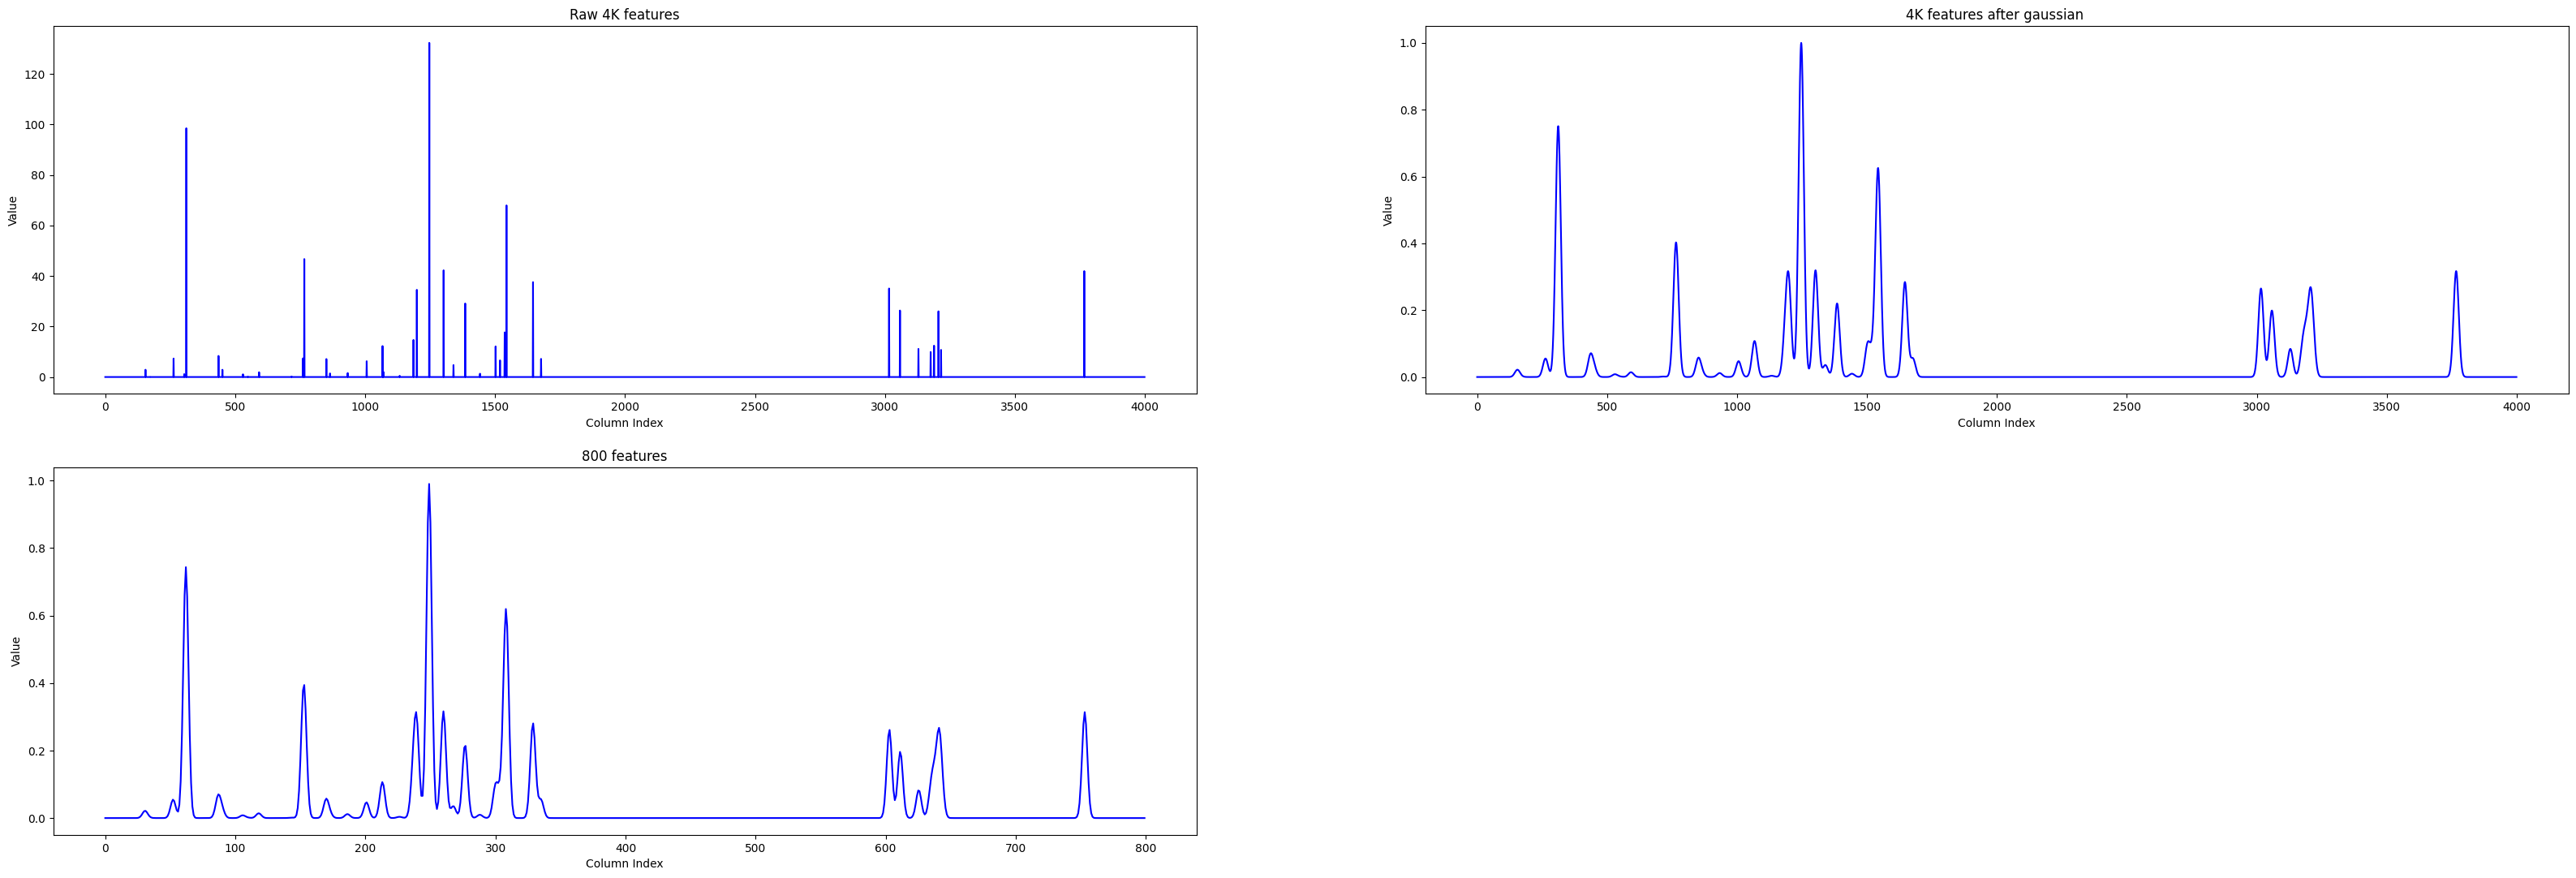

In [7]:
plt.figure(figsize=(40,20))
plt.subplot(321)
plt.plot(b,'b')
plt.xlabel("Column Index")
plt.ylabel("Value")
plt.title("Raw 4K features")

plt.subplot(322)
plt.plot(a,'b')
plt.xlabel("Column Index")
plt.ylabel("Value")
plt.title("4K features after gaussian ")

plt.subplot(323)
third_row = df.iloc[0]
x_values1 = np.arange(len(third_row))
plt.plot(third_row,'b')
plt.xlabel("Column Index")
plt.ylabel("Value")
plt.title("800 features")
plt.show()

In [8]:
pip install pyts


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 10.8 MB/s eta 0:00:00


In [9]:
import numpy as np
import pandas as pd
from pyts.image import RecurrencePlot, MarkovTransitionField
from pyts.image import GramianAngularField
from scipy.ndimage import zoom
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing import image

# start_column = "0"
# end_column = "799"
# start_idx = df.columns.get_loc(start_column)
# end_idx = df.columns.get_loc(end_column)
# sliced_df = df.iloc[:, start_idx:end_idx + 1]
data = df.values
gasf_transformer = GramianAngularField(image_size=225, method='summation')
gadf_transformer = GramianAngularField(image_size=225, method='difference')
rp_transformer = RecurrencePlot()
mtf_transformer = MarkovTransitionField(image_size=225)
reshaped_data = np.empty((data.shape[0], 225, 225, 3))
for i in range(data.shape[0]):
    row = data[i]
    # row1= data1[i]
    gasf = gasf_transformer.fit_transform(row.reshape(1, -1))[0]
    rp = rp_transformer.fit_transform(row.reshape(1, -1))[0]
    rp = zoom(rp, (225 / rp.shape[0], 225 / rp.shape[1]), order=1)
    gadf=gadf_transformer.fit_transform(row.reshape(1, -1))[0]
    mtf = mtf_transformer.fit_transform(row.reshape(1, -1))[0]
    reshaped_data[i, :, :, 0] = gasf
    reshaped_data[i, :, :, 1] = gadf
    reshaped_data[i, :, :, 2] = mtf


/usr/local/lib/python3.10/dist-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


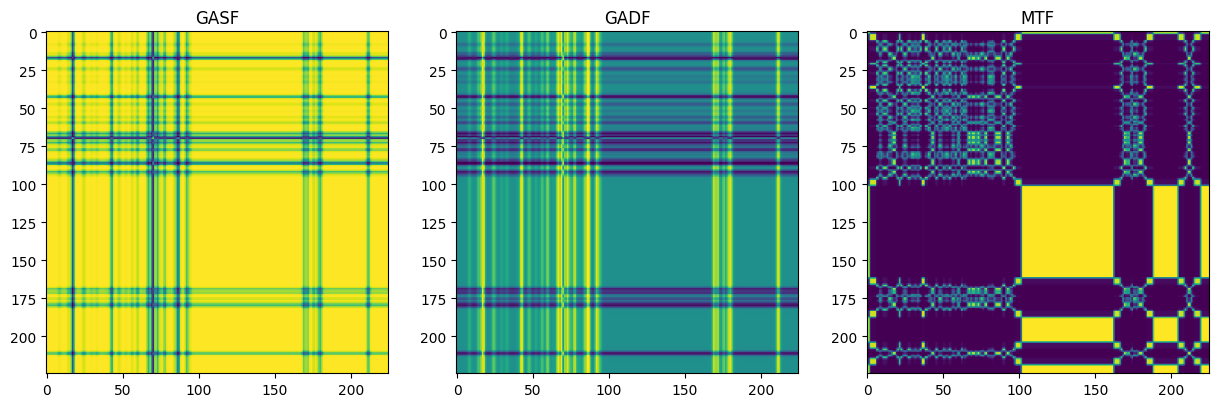

In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(reshaped_data[0, :, :, 0], cmap='viridis')
plt.title('GASF')
plt.subplot(132)
plt.imshow(reshaped_data[0, :, :, 1], cmap='viridis')
plt.title('GADF')
plt.subplot(133)
plt.imshow(reshaped_data[0, :, :, 2], cmap='viridis')
plt.title('MTF')

plt.show()
